# Project Overview and Data Description

For this project, the goal is to create a generative adversarial network (GAN) composed of a generator model and a discriminator model to generate 7,000 to 10,000 Monet-style images.

A GAN Model has a generator which focuses on creating fake that to mimic real data. It starts with random noise and tunes the noise until it closely matches real data. To tune the noise into real data, it relies on a discriminator. The discriminator will evaluate the data and attempt to distinguis the real data from the fake data. The output of this model is then used to improve the generated images that the generator made such that the loss between the real and fake images is minimized. 

Through this model design, the networks work against each other to improve the performance of both: the generator tries to make it harder for the discriminator to determine the difference between real and fake, and the discriminator tries to better determine real from fake to improve how the generator makes images. Hence, they are considered 'adverserial'.


The dataset comes from [Kaggle Competition](https://www.kaggle.com/competitions/gan-getting-started/overview)

It includes 300 Monet style images to learn from, and 7038 images to generate into Monet Style images. Each image is a 256 x 256 RBG image (256,256,3) in jpeg format. 



In [68]:
#import libraries and dataset:

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os 
import matplotlib.pyplot as plt
import numpy as np
import random


from tensorflow.keras.layers import (Input, Conv2D, Conv2DTranspose, BatchNormalization, Activation, 
                                        Concatenate, Dropout,ZeroPadding2D, LeakyReLU, ReLU)
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy



In [59]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()

In [19]:

GCS_PATH = './gan-getting-started'
MONET_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/monet_jpg/*.jpg'))
print('Monet TFRecord Files:', len(MONET_FILENAMES))

PHOTO_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/photo_jpg/*.jpg'))
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))


Monet TFRecord Files: 300
Photo TFRecord Files: 7038


## Exploratory analysis

Here, the goal is to look at the pictures and load them into datasets that will be passed into the GAN model.

To plot the images, we'll import them into a dataset from tensor slices. The images will need to be shaped to the right dimensions as well.

In [40]:
IMG_WIDTH = 256
IMG_HEIGHT = 256

def load_and_preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMG_WIDTH, IMG_HEIGHT])
    image = (image / 127.5) - 1 
    return image

def load_dataset(image_paths):
    dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    dataset = dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    return dataset.batch(1)

In [41]:
monet_ds = load_dataset(MONET_FILENAMES)
photo_ds = load_dataset(PHOTO_FILENAMES)

2024-06-21 21:09:13.910713: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


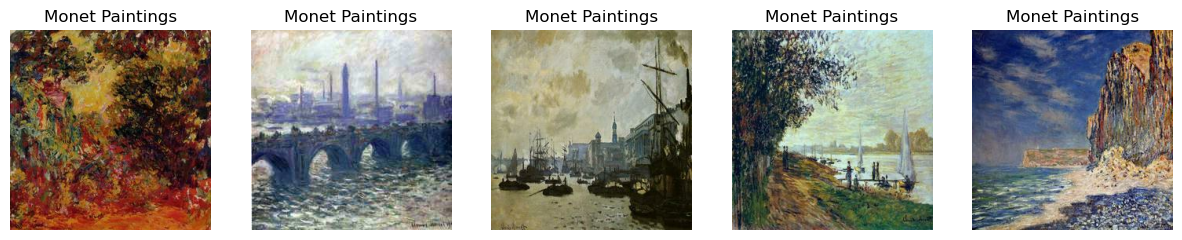

2024-06-21 21:09:14.082463: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


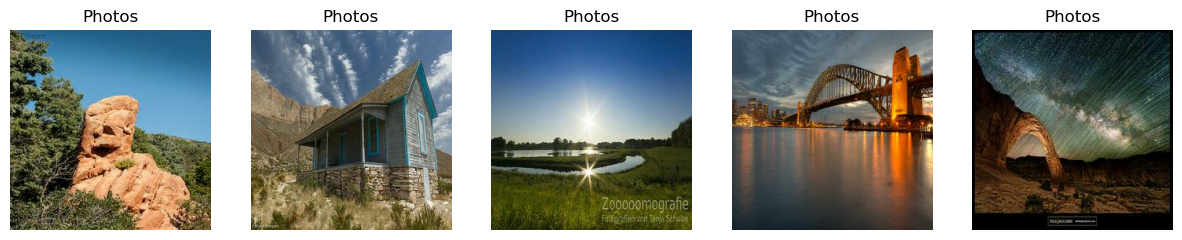

In [42]:
def plot_images(dataset, title, num_images=5):
    plt.figure(figsize=(15, 15))
    for i, image in enumerate(dataset.take(num_images)):
        ax = plt.subplot(1, num_images, i + 1)
        plt.imshow((image[0].numpy() + 1) / 2)  # De-normalize to [0, 1] range for display
        plt.title(title)
        plt.axis("off")
    plt.show()

# Example usage
plot_images(monet_ds, "Monet Paintings", num_images=5)
plot_images(photo_ds, "Photos", num_images=5)

The Monet paintings have a distinct quality of color contrasts and some effect similar to pixalating. The photos seem to be of the outside, with rich colors. I think from here, it would be interesting to see how the different amounts of reds, greens, and blues are in the monet paintings versus the real photos, since paintings can have colors in different proportions like more yellows and reds instead of blues and greens of real photos. I'll plot the distribution of RBGs in each.

Another feature of the photos is the resolution. Because higher resolution requires more pixels to be passed into the model, the model will need to have a deeper structure than images of lower resolution. I will see the resolution of the photos to help determine how many convolutional layers to use.

In [ ]:
def collect_color_values(dataset):
    reds, greens, blues = [], [], []
    
    for image_batch in dataset:
        image = image_batch[0]  
        reds.extend(image[:, :, 0].numpy().flatten())
        greens.extend(image[:, :, 1].numpy().flatten())
        blues.extend(image[:, :, 2].numpy().flatten())
    
    return np.array(reds), np.array(greens), np.array(blues)

def plot_color_distributions(reds, greens, blues, title):
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.hist(reds, bins=50, color='red', alpha=0.7)
    plt.title('Red Channel')
    
    plt.subplot(1, 3, 2)
    plt.hist(greens, bins=50, color='green', alpha=0.7)
    plt.title('Green Channel')
    
    plt.subplot(1, 3, 3)
    plt.hist(blues, bins=50, color='blue', alpha=0.7)
    plt.title('Blue Channel')
    
    plt.suptitle(title)
    plt.show()

monet_reds, monet_greens, monet_blues = collect_color_values(monet_ds)
photo_reds, photo_greens, photo_blues = collect_color_values(photo_ds)

plot_color_distributions(monet_reds, monet_greens, monet_blues, 'Monet Dataset Color Distribution')
plot_color_distributions(photo_reds, photo_greens, photo_blues, 'Photo Dataset Color Distribution')



In [ ]:
def get_dataset_resolutions(image_paths):
    resolutions = []
    for image_path in image_paths:
        image = tf.io.read_file(image_path)
        image = tf.image.decode_image(image)
        resolution = image.shape[:2]
        resolutions.append(resolution)
    return resolutions

monet_resolutions = get_dataset_resolutions(MONET_FILENAMES)
photo_resolutions = get_dataset_resolutions(PHOTO_FILENAMES)


In [ ]:
monet_heights, monet_widths = zip(*monet_resolutions)
photo_heights, photo_widths = zip(*photo_resolutions)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(monet_heights, bins=50, color='skyblue', alpha=0.7, label='Heights')
plt.hist(monet_widths, bins=50, color='salmon', alpha=0.7, label='Widths')
plt.title('Monet Dataset Resolution Distribution')
plt.xlabel('Pixels')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(photo_heights, bins=50, color='skyblue', alpha=0.7, label='Heights')
plt.hist(photo_widths, bins=50, color='salmon', alpha=0.7, label='Widths')
plt.title('Photo Dataset Resolution Distribution')
plt.xlabel('Pixels')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(monet_widths, monet_heights, alpha=0.5, color='blue')
plt.title('Monet Dataset Resolution Scatter Plot')
plt.xlabel('Width (pixels)')
plt.ylabel('Height (pixels)')

plt.subplot(1, 2, 2)
plt.scatter(photo_widths, photo_heights, alpha=0.5, color='red')
plt.title('Photo Dataset Resolution Scatter Plot')
plt.xlabel('Width (pixels)')
plt.ylabel('Height (pixels)')

plt.tight_layout()
plt.show()


# Model Building

Now, the data is ready to be used in training the model. Let's build it. 

For this model, I wanted to use simple convolutional layers with batch normalization and leaky relu (to allow values to be slightly negative, instead of zero which would remove a node and affect model learning). The layers will follow a symmetric downsampling and upsampling of nodes : 64 -> 128 -> 256 -> 512 for a 5-8 layers then ->256 ->128 -> 64

Because of the resolution of the photos, it will be helpful to have a deeper model that can learn more details in the images. This will increase the risk of losing spatial information about the photo, though skipping layers in the upstack can help balance that. Additionally, skipping some layers in the upstack will help prevent the gradients from vanishing during back propagation. It will also preserve information from lower layers which can help the model learn more abstract relationships between the features.  




In [62]:
def build_generator():
    def downsample(filters, size, apply_batchnorm=True):
        initializer = tf.random_normal_initializer(0., 0.02)
        result = tf.keras.Sequential()
        result.add(
            Conv2D(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False)
        )
        if apply_batchnorm:
            result.add(BatchNormalization())
        result.add(LeakyReLU())
        return result

    def upsample(filters, size, apply_dropout=False):
        initializer = tf.random_normal_initializer(0., 0.02)
        result = tf.keras.Sequential()
        result.add(
            Conv2DTranspose(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False)
        )
        result.add(BatchNormalization())
        if apply_dropout:
            result.add(Dropout(0.5))
        result.add(ReLU())
        return result

    inputs = Input(shape=[256, 256, 3])
    down_stack = [
        downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
        downsample(128, 4),  # (batch_size, 64, 64, 128)
        downsample(256, 4),  # (batch_size, 32, 32, 256)
        downsample(512, 4),  # (batch_size, 16, 16, 512)
        downsample(512, 4),  # (batch_size, 8, 8, 512)
        downsample(512, 4),  # (batch_size, 4, 4, 512)
        downsample(512, 4),  # (batch_size, 2, 2, 512)
        downsample(512, 4),  # (batch_size, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
        upsample(512, 4),  # (batch_size, 16, 16, 1024)
        upsample(256, 4),  # (batch_size, 32, 32, 512)
        upsample(128, 4),  # (batch_size, 64, 64, 256)
        upsample(64, 4),  # (batch_size, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = Conv2DTranspose(3, 4, strides=2, padding='same', kernel_initializer=initializer, activation='tanh')  # (batch_size, 256, 256, 3)

    x = inputs
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    skips = reversed(skips[:-1])

    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = Concatenate()([x, skip])

    x = last(x)
    return Model(inputs=inputs, outputs=x)


In [63]:
def build_discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inputs = Input(shape=[256, 256, 3])

    x = Conv2D(64, 4, strides=2, padding='same', kernel_initializer=initializer)(inputs)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(128, 4, strides=2, padding='same', kernel_initializer=initializer)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(256, 4, strides=2, padding='same', kernel_initializer=initializer)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(512, 4, strides=1, padding='same', kernel_initializer=initializer)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    last = Conv2D(1, 4, strides=1, padding='same', kernel_initializer=initializer)(x)

    return Model(inputs=inputs, outputs=last)


In [64]:
with strategy.scope():
    gen_G = build_generator()
    gen_F = build_generator()

    disc_X = build_discriminator()
    disc_Y = build_discriminator()

with strategy.scope():
    gen_G_optimizer = Adam(2e-4, beta_1=0.5)
    gen_F_optimizer = Adam(2e-4, beta_1=0.5)

    disc_X_optimizer = Adam(2e-4, beta_1=0.5)
    disc_Y_optimizer = Adam(2e-4, beta_1=0.5)

## Calculate the Loss

The discriminator loss focuses on how many images it labeled correctly as real and correctly as fake. Because the discriminator's purpose is to better tell what is real and what is fake, classifying something as real when it is fake (false positive) or classifying something as fake when it is real (false negative) needs to be minimized. 

The generator loss focuses on how many fake images were labeled as fake because it is a measure of how different the fake data is from real data. When the fake data is close to the real data, the number of fake data labeled as fake will be minimized. 

The consistency loss and identity loss are meant to control how much the image changes from the begining of the cycle to the end. A perfect model can decode and encode a picture with no difference made to the picture. Hence, for these, I am calculating the difference between the real image and the made image and minimizing the difference between the two.


In [65]:
with strategy.scope():
    def discriminator_loss(real_output, fake_output):
        real_loss = BinaryCrossentropy(from_logits=True)(tf.ones_like(real_output), real_output)
        fake_loss = BinaryCrossentropy(from_logits=True)(tf.zeros_like(fake_output), fake_output)
        total_loss = real_loss + fake_loss
        return total_loss

    
with strategy.scope():
    def generator_loss(fake_output):
        return BinaryCrossentropy(from_logits=True)(tf.ones_like(fake_output), fake_output)

with strategy.scope():
    def cycle_consistency_loss(real_image, cycled_image):
        loss = tf.reduce_mean(tf.abs(real_image - cycled_image))
        return loss

with strategy.scope():
    def identity_loss(real_image, same_image):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return loss


lambda_cycle = 10
lambda_identity = 0.5

with strategy.scope():
    def calc_generator_loss(gen_G, gen_F, disc_X, disc_Y, real_X, real_Y):
        fake_Y = gen_G(real_X, training=True)
        cycled_X = gen_F(fake_Y, training=True)

        fake_X = gen_F(real_Y, training=True)
        cycled_Y = gen_G(fake_X, training=True)

        same_X = gen_F(real_X, training=True)
        same_Y = gen_G(real_Y, training=True)

        disc_fake_Y = disc_Y(fake_Y, training=True)
        disc_fake_X = disc_X(fake_X, training=True)

        gen_G_loss = generator_loss(disc_fake_Y)
        gen_F_loss = generator_loss(disc_fake_X)

        total_cycle_loss = cycle_consistency_loss(real_X, cycled_X) + cycle_consistency_loss(real_Y, cycled_Y)

        total_gen_G_loss = gen_G_loss + (lambda_cycle * total_cycle_loss) + (lambda_identity * identity_loss(real_Y, same_Y))
        total_gen_F_loss = gen_F_loss + (lambda_cycle * total_cycle_loss) + (lambda_identity * identity_loss(real_X, same_X))

        return total_gen_G_loss, total_gen_F_loss

with strategy.scope():
    def calc_discriminator_loss(disc_X, disc_Y, real_X, real_Y, fake_X, fake_Y):
        disc_real_X = disc_X(real_X, training=True)
        disc_real_Y = disc_Y(real_Y, training=True)
        disc_fake_X = disc_X(fake_X, training=True)
        disc_fake_Y = disc_Y(fake_Y, training=True)

        disc_X_loss = discriminator_loss(disc_real_X, disc_fake_X)
        disc_Y_loss = discriminator_loss(disc_real_Y, disc_fake_Y)

        return disc_X_loss, disc_Y_loss




## Training

In the training step, the model will cycle through a generator and discriminator and then calculate the losses between the real image and fake image for every image. It will repeat this for the set number of epochs. 

In [66]:
def train_step(real_x, real_y):
    with tf.GradientTape(persistent=True) as tape:
        fake_y = gen_G(real_x, training=True)
        cycled_x = gen_F(fake_y, training=True)

        fake_x = gen_F(real_y, training=True)
        cycled_y = gen_G(fake_x, training=True)

        same_x = gen_F(real_x, training=True)
        same_y = gen_G(real_y, training=True)

        disc_real_x = disc_X(real_x, training=True)
        disc_real_y = disc_Y(real_y, training=True)
        disc_fake_x = disc_X(fake_x, training=True)
        disc_fake_y = disc_Y(fake_y, training=True)

        gen_G_loss = generator_loss(disc_fake_y)
        gen_F_loss = generator_loss(disc_fake_x)

        total_cycle_loss = cycle_consistency_loss(real_x, cycled_x) + cycle_consistency_loss(real_y, cycled_y)
        total_gen_G_loss = gen_G_loss + total_cycle_loss + identity_loss(real_y, same_y)
        total_gen_F_loss = gen_F_loss + total_cycle_loss + identity_loss(real_x, same_x)

        disc_X_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_Y_loss = discriminator_loss(disc_real_y, disc_fake_y)

    gen_G_gradients = tape.gradient(total_gen_G_loss, gen_G.trainable_variables)
    gen_F_gradients = tape.gradient(total_gen_F_loss, gen_F.trainable_variables)
    gen_G_optimizer.apply_gradients(zip(gen_G_gradients, gen_G.trainable_variables))
    gen_F_optimizer.apply_gradients(zip(gen_F_gradients, gen_F.trainable_variables))

    disc_X_gradients = tape.gradient(disc_X_loss, disc_X.trainable_variables)
    disc_Y_gradients = tape.gradient(disc_Y_loss, disc_Y.trainable_variables)
    disc_X_optimizer.apply_gradients(zip(disc_X_gradients, disc_X.trainable_variables))
    disc_Y_optimizer.apply_gradients(zip(disc_Y_gradients, disc_Y.trainable_variables))

    return total_gen_G_loss, total_gen_F_loss, disc_X_loss, disc_Y_loss

In [67]:

EPOCHS = 20

for epoch in range(EPOCHS):
    for real_X, real_Y in tf.data.Dataset.zip((monet_ds, photo_ds)):
        gen_G_loss, gen_F_loss, disc_X_loss, disc_Y_loss = train_step(real_X, real_Y)
    print(f'Epoch: {epoch + 1}, Gen G Loss: {gen_G_loss}, Gen F Loss: {gen_F_loss}, Disc X Loss: {disc_X_loss}, Disc Y Loss: {disc_Y_loss}')

2024-06-21 21:48:58.675384: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch: 1, Gen G Loss: 1.1221323013305664, Gen F Loss: 1.4063879251480103, Disc X Loss: 1.5154216289520264, Disc Y Loss: 1.4563629627227783


2024-06-21 22:12:23.718218: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch: 2, Gen G Loss: 1.0664616823196411, Gen F Loss: 1.3404852151870728, Disc X Loss: 1.5705121755599976, Disc Y Loss: 1.4579402208328247


2024-06-21 22:35:48.006704: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch: 3, Gen G Loss: 1.0405759811401367, Gen F Loss: 1.3315225839614868, Disc X Loss: 1.5666987895965576, Disc Y Loss: 1.4656093120574951


2024-06-21 22:59:09.004382: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch: 4, Gen G Loss: 1.031544804573059, Gen F Loss: 1.3269386291503906, Disc X Loss: 1.5324560403823853, Disc Y Loss: 1.4512965679168701


2024-06-21 23:22:36.768247: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch: 5, Gen G Loss: 1.0103105306625366, Gen F Loss: 1.3290306329727173, Disc X Loss: 1.5255560874938965, Disc Y Loss: 1.4546279907226562


2024-06-21 23:46:28.525876: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch: 6, Gen G Loss: 0.9763908386230469, Gen F Loss: 1.322261095046997, Disc X Loss: 1.4781785011291504, Disc Y Loss: 1.447960615158081


2024-06-22 00:10:04.871253: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch: 7, Gen G Loss: 1.0033056735992432, Gen F Loss: 1.328277349472046, Disc X Loss: 1.4890739917755127, Disc Y Loss: 1.4470157623291016


2024-06-22 00:33:32.402478: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch: 8, Gen G Loss: 1.0112462043762207, Gen F Loss: 1.3888670206069946, Disc X Loss: 1.4782822132110596, Disc Y Loss: 1.4528436660766602


2024-06-22 00:57:04.276719: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch: 9, Gen G Loss: 1.0098111629486084, Gen F Loss: 1.307952642440796, Disc X Loss: 1.439143419265747, Disc Y Loss: 1.4131557941436768


2024-06-22 01:20:46.455786: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch: 10, Gen G Loss: 0.9489245414733887, Gen F Loss: 1.21686589717865, Disc X Loss: 1.3783361911773682, Disc Y Loss: 1.423642635345459


2024-06-22 01:44:16.774691: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch: 11, Gen G Loss: 1.1678732633590698, Gen F Loss: 1.545123815536499, Disc X Loss: 1.4035005569458008, Disc Y Loss: 1.4018782377243042


2024-06-22 02:07:36.472210: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch: 12, Gen G Loss: 1.084843397140503, Gen F Loss: 1.510429859161377, Disc X Loss: 1.369927167892456, Disc Y Loss: 1.4265483617782593


2024-06-22 02:30:52.163473: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch: 13, Gen G Loss: 1.0101275444030762, Gen F Loss: 1.1555153131484985, Disc X Loss: 1.3798363208770752, Disc Y Loss: 1.3500025272369385


2024-06-22 02:54:09.892787: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch: 14, Gen G Loss: 0.9666089415550232, Gen F Loss: 1.2288997173309326, Disc X Loss: 1.3394269943237305, Disc Y Loss: 1.3552268743515015


2024-06-22 03:17:44.240435: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch: 15, Gen G Loss: 0.9621390700340271, Gen F Loss: 1.1394034624099731, Disc X Loss: 1.3605616092681885, Disc Y Loss: 1.3449013233184814


2024-06-22 03:41:29.354809: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch: 16, Gen G Loss: 1.071860909461975, Gen F Loss: 1.3143388032913208, Disc X Loss: 1.3949905633926392, Disc Y Loss: 1.3189364671707153


2024-06-22 04:05:20.276065: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch: 17, Gen G Loss: 0.986842155456543, Gen F Loss: 1.1371718645095825, Disc X Loss: 1.3633840084075928, Disc Y Loss: 1.3349039554595947


2024-06-22 04:29:16.170383: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch: 18, Gen G Loss: 0.9927896857261658, Gen F Loss: 1.1130717992782593, Disc X Loss: 1.3883832693099976, Disc Y Loss: 1.3278775215148926


2024-06-22 04:53:20.666898: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch: 19, Gen G Loss: 1.0867441892623901, Gen F Loss: 1.138014793395996, Disc X Loss: 1.3550238609313965, Disc Y Loss: 1.2898778915405273
Epoch: 20, Gen G Loss: 1.0570341348648071, Gen F Loss: 1.0727771520614624, Disc X Loss: 1.3933556079864502, Disc Y Loss: 1.3141096830368042


2024-06-22 05:17:36.764261: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Generated images

Let's look at how the images look! 

2024-06-22 08:22:44.280278: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


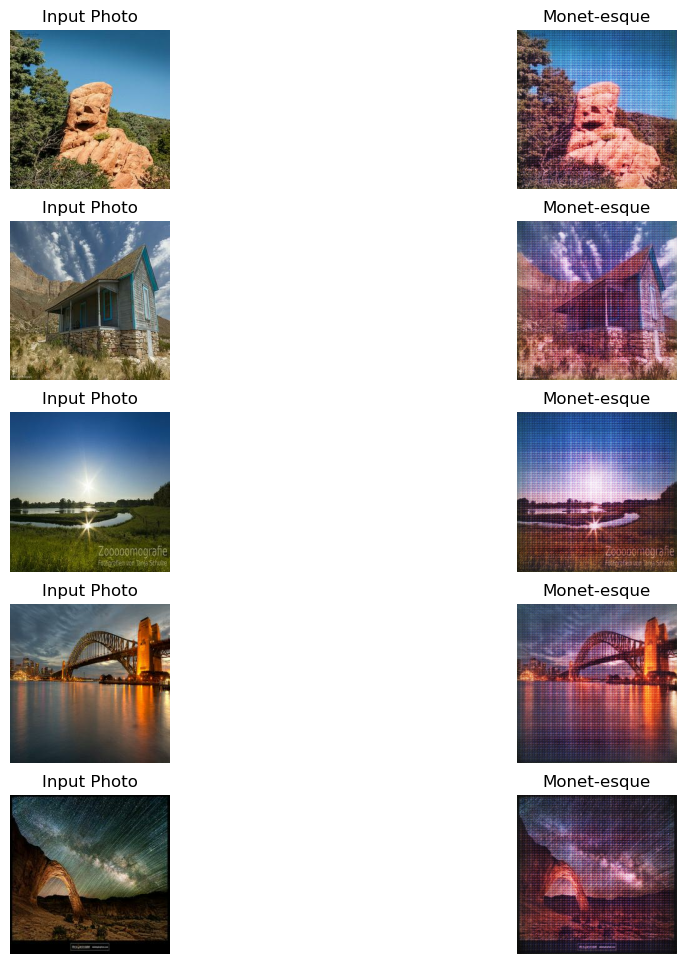

In [71]:
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(photo_ds.take(5)):
    prediction = gen_G(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

In [72]:
import PIL
! mkdir ../images

i = 1
for img in photo_ds:
    prediction = gen_G(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("../images/" + str(i) + ".jpg")
    i += 1
    
import shutil
shutil.make_archive("./", 'zip', "/kaggle/images")

2024-06-22 08:36:01.673504: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


'/home/pbadass/Documents/week 5 project/.zip'

# Results and Conclusion

The image dimensions required a deeper model for the downsampling and upsampling in order for the model to be able to learn the finer details of the images. This increase in depth (number of layers) in addition to the increase in complexity (number of nodes per layer) dramatically increased the computational demands. For this reason, I did not do any hyperparameter tuning. 

However, many other lessons were learned about training the model. For example, training the model using a smaller batch of data could be used for tuning the number of layers needed to learn. From there, it would be helpful to implement some kind of learning rate scheduler to achieve the optimal learning rate to use.  

Additionally, being able to use GPU for this model training would allow me to train the model faster (thus allowing me to adjust it as needed more quickly). 